# Patrick Hearin Ph.D.
## NLP with Long-Short-Term Model in TensorFlow

Project: Tweet Emotion Classification

Objective: Build a model that can automatically classify tweets into different emotions (e.g., anger, joy, sadness, fear, etc.) based on their textual content.

Approach:

Data: Use the Tweet Emotion dataset, which contains tweets labeled with their corresponding emotions.

Preprocessing:

Clean the tweets (remove URLs, mentions, hashtags, etc.).
Tokenize the tweets into individual words or subwords.
Build a vocabulary and convert words to numerical representations (e.g., using word embeddings).
Pad/truncate sequences to a consistent length.
Model:

Use an Embedding layer to represent words as dense vectors.
Employ an LSTM layer to capture sequential dependencies in the tweet text.
Add a dense layer with a softmax activation function for multi-class classification (multiple emotions).
Training:

Compile the model with a suitable loss function (e.g., categorical cross-entropy) and optimizer (e.g., Adam).
Train the model on the preprocessed dataset.
Evaluation:

Assess the model's performance on a separate test set using metrics like accuracy, precision, recall, and F1-score for each emotion class.
Consider generating a confusion matrix to visualize the model's strengths and weaknesses.

# Uncomment this to install the dataset used for this project.

In [33]:
#!pip install datasets

Load all the libraries needed.

In [34]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.17.0


# Import the datasets for the project.

In [35]:
import datasets

In [36]:
data = datasets.load_dataset('emotion')

In [37]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [38]:
train = data['train']
test = data['test']
val=data['validation']

In [39]:
def get_tweet(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [40]:
tweets, labels = get_tweet(train)

In [41]:
tweets[0], labels[0]

('i didnt feel humiliated', 0)

# Tokenization

In [42]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [43]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [44]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [45]:
tweets[0]

'i didnt feel humiliated'

# Padding and Truncating Sequences

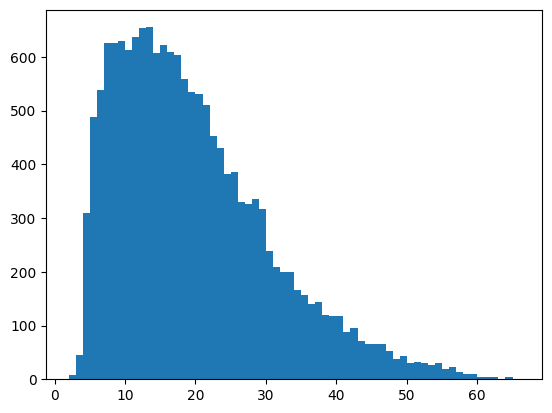

In [46]:

import matplotlib.pyplot as plt

lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [47]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [48]:
get_sequences2 = lambda x: pad_sequences(tokenizer.texts_to_sequences(x), maxlen=maxlen, padding='post', truncating='post')

In [49]:
def get_sequences(tokenizer, x):
  sequences = tokenizer.texts_to_sequences(x)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [50]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [51]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)


# Preparing the Labels

In [52]:
classes = set(labels)
classes

{0, 1, 2, 3, 4, 5}

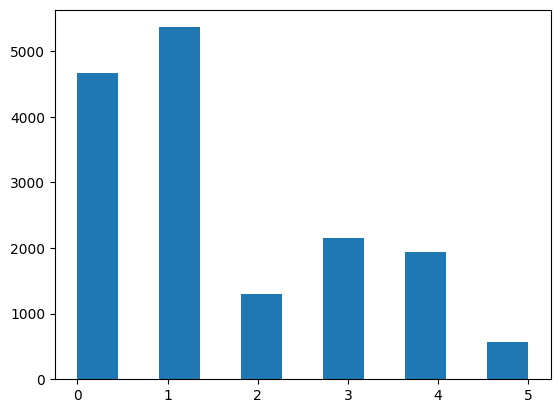

In [53]:
plt.hist(labels, bins=11)
plt.show()

In the context of the Tweet Emotion dataset, an imbalanced dataset means that some emotion categories have significantly more examples (tweets) than others. This imbalance can pose a challenge for machine learning models, as they might become biased towards the majority classes and struggle to accurately classify the minority classes. Addressing this imbalance is often crucial to ensure fair and effective emotion classification. Techniques like resampling (oversampling minority classes or undersampling majority classes) or using specialized loss functions can help mitigate the effects of an imbalanced dataset.

In [54]:
classes_to_index = dict((c,i) for i,c in enumerate(classes))
classes_to_index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [55]:
index_to_classes = dict((v,k) for k,v in classes_to_index.items())
index_to_classes

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [56]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])


In [57]:
names_to_ids(labels[:5])

array([0, 0, 3, 2, 3])

# Creating the Model

In [58]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
    ])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [59]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Training the Model

In [65]:
train_tweet, train_labels = get_tweet(train)

In [60]:
val_tweet, val_labels = get_tweet(val)

In [61]:
val_seq = get_sequences(tokenizer, val_tweet)

In [62]:
val_labels = names_to_ids(val_labels)

In [63]:
val_tweet[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

# This is a small test model.

In [32]:
h = model.fit(padded_train_seq, names_to_ids(labels), epochs=10, validation_data=(val_seq, val_labels), verbose=2)

Epoch 1/10
500/500 - 39s - 78ms/step - accuracy: 0.4704 - loss: 1.3523 - val_accuracy: 0.6775 - val_loss: 0.8888
Epoch 2/10
500/500 - 52s - 104ms/step - accuracy: 0.7973 - loss: 0.5817 - val_accuracy: 0.8220 - val_loss: 0.5271
Epoch 3/10
500/500 - 45s - 90ms/step - accuracy: 0.8829 - loss: 0.3442 - val_accuracy: 0.8460 - val_loss: 0.4762
Epoch 4/10
500/500 - 67s - 135ms/step - accuracy: 0.9256 - loss: 0.2287 - val_accuracy: 0.8680 - val_loss: 0.4209
Epoch 5/10
500/500 - 39s - 78ms/step - accuracy: 0.9427 - loss: 0.1785 - val_accuracy: 0.8725 - val_loss: 0.3945
Epoch 6/10
500/500 - 40s - 80ms/step - accuracy: 0.9559 - loss: 0.1400 - val_accuracy: 0.8790 - val_loss: 0.4154
Epoch 7/10
500/500 - 28s - 57ms/step - accuracy: 0.9659 - loss: 0.1164 - val_accuracy: 0.8835 - val_loss: 0.3941
Epoch 8/10
500/500 - 41s - 83ms/step - accuracy: 0.9705 - loss: 0.0968 - val_accuracy: 0.8810 - val_loss: 0.4330
Epoch 9/10
500/500 - 40s - 80ms/step - accuracy: 0.9771 - loss: 0.0803 - val_accuracy: 0.8915 

# Full model.

In [67]:
h = model.fit(
    padded_train_seq,
    names_to_ids(labels),
    epochs=20,
    validation_data=(val_seq, val_labels),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)],
    verbose=2)

Epoch 1/20
500/500 - 39s - 77ms/step - accuracy: 0.4584 - loss: 1.3661 - val_accuracy: 0.6675 - val_loss: 0.9038
Epoch 2/20
500/500 - 41s - 82ms/step - accuracy: 0.7932 - loss: 0.6023 - val_accuracy: 0.8180 - val_loss: 0.5521
Epoch 3/20
500/500 - 41s - 83ms/step - accuracy: 0.8907 - loss: 0.3278 - val_accuracy: 0.8630 - val_loss: 0.4436
Epoch 4/20
500/500 - 40s - 81ms/step - accuracy: 0.9292 - loss: 0.2211 - val_accuracy: 0.8690 - val_loss: 0.4119
Epoch 5/20
500/500 - 28s - 57ms/step - accuracy: 0.9493 - loss: 0.1595 - val_accuracy: 0.8810 - val_loss: 0.4039
Epoch 6/20
500/500 - 43s - 87ms/step - accuracy: 0.9588 - loss: 0.1314 - val_accuracy: 0.8860 - val_loss: 0.3902
Epoch 7/20
500/500 - 40s - 80ms/step - accuracy: 0.9643 - loss: 0.1128 - val_accuracy: 0.8880 - val_loss: 0.3954
Epoch 8/20
500/500 - 43s - 86ms/step - accuracy: 0.9755 - loss: 0.0805 - val_accuracy: 0.8950 - val_loss: 0.3798
Epoch 9/20
500/500 - 41s - 81ms/step - accuracy: 0.9786 - loss: 0.0728 - val_accuracy: 0.8935 - 

# Conclusions

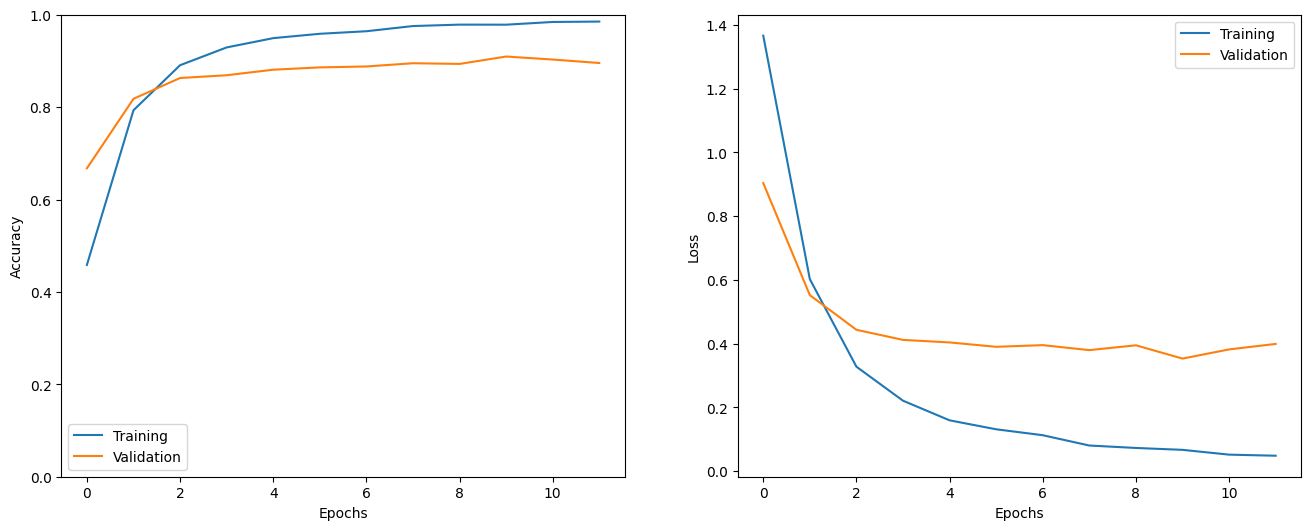

In [68]:
show_history(h)

In [69]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

# Final Test Data Set Accuracy and Loss

In [70]:
_ = model.evaluate(test_seq, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8918 - loss: 0.4092


A test accuracy of 0.8918 is a very good result, indicating that the model is performing well on unseen data. It suggests that the model has learned effectively from the training data and generalizes well to new examples.

However, it's important to consider several factors before drawing definitive conclusions:

Baseline and Task Complexity:

How does this accuracy compare to a simple baseline model or human-level performance on this task? A high accuracy might be less impressive if the task is simple or a baseline model achieves a similar result.
If the task is complex and/or human performance is lower, 0.8918 is a strong indicator of a successful model.
Class Imbalance:

If the dataset is imbalanced (some classes have significantly fewer examples), accuracy alone can be misleading. It's essential to examine other metrics like precision, recall, and F1-score, particularly for the minority classes.
Real-World Implications:

Consider the consequences of misclassifications in the context of your application. Even a seemingly small error rate can be significant depending on the use case.
For example, in medical diagnosis, a false negative (incorrectly predicting a patient is healthy) could have serious consequences.
Overall:

A test accuracy of 0.8918 is promising and indicates that the model has the potential to be useful in real-world applications. However, further analysis and consideration of other factors are necessary to fully understand its performance and suitability for deployment.

# Individual Predictions

In [74]:
i = random.randint(0, len(test_tweets) - 1)

print(test_tweets[i])
print('Actual class: ', index_to_classes[test_labels[i]])



i feel kinda lousy about myself
Actual class:  0


In [77]:
p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


In [78]:
pred_class = index_to_classes[np.argmax(p).astype('uint8')]

In [79]:
print('Predicted class: ', pred_class)

Predicted class:  0


In [80]:
preds = model.predict(test_seq)

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step


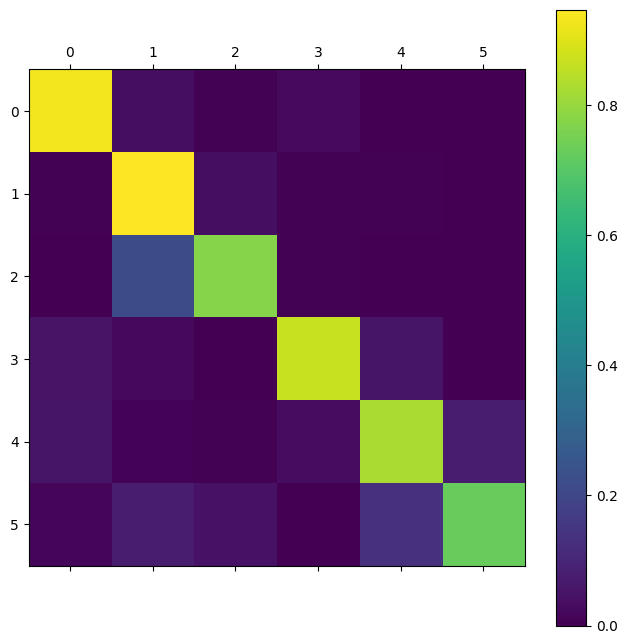

In [81]:
show_confusion_matrix(test_labels, preds.argmax(axis=1), list(classes))

This shows that their is some difficulty in the model confusing some of the emotions.